In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
os.makedirs("/content/drive/MyDrive/DLassignment2/models", exist_ok=True)

Mounted at /content/drive


In [2]:
# Hyperparameters
num_epochs = 100
batch_size = 64
learning_rate = 0.1
#weight_decay_options = [1e-4, 5e-4]
weight_decay_options = [5e-4]
#optimizers = ['SGD', 'Adam']
optimizers = ['Adam']
patience = 5


In [3]:
# Data transforms
transform_train = transforms.Compose([
    #transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224, padding=4),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    #transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


In [5]:
# Load dataset and split into train, val, and test sets
train_dataset = datasets.CIFAR10(root='/content/data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='/content/data', train=False, transform=transform_test, download=True)

seed_value = 42
torch.manual_seed(seed_value)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for data, _ in train_loader:
    print(data.shape)
    break

torch.Size([64, 3, 32, 32])


In [6]:

# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()




# Training function
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler=None):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Load checkpoint if available
    checkpoint_path = '/content/drive/MyDrive/DLassignment2/models/resnet18_best.pth'
    start_epoch = 0
    if os.path.isfile(checkpoint_path):
        print("Loading checkpoint...")
        model.load_state_dict(torch.load(checkpoint_path))

    # Lists to store training/validation loss and accuracy for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            train_loss += loss.item()

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_accuracy = 100. * correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(val_loader):
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check for improvement & save the model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/DLassignment2/models/resnet18_best.pth')
            print(f"New best model saved at epoch {epoch+1} with validation loss {val_loss:.4f}")
        else:
            epochs_without_improvement += 1

        # Early stopping condition
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation loss {best_val_loss:.4f}")
            break

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, '
              f'Train Acc: {train_accuracies[-1]:.2f}, Val Loss: {val_losses[-1]:.4f}, '
              f'Val Acc: {val_accuracies[-1]:.2f}')


        # Step the scheduler
        if scheduler:
            scheduler.step(val_loss)

    # Plotting the training and validation metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    print(f"train_loss: {train_losses}")
    print(f"val_loss: {val_losses}")
    print(f"train_acc: {train_accuracies}")
    print(f"val_acc: {val_accuracies}")






Training model with Adam optimizer and weight decay 0.0005


100%|██████████| 625/625 [01:08<00:00,  9.08it/s]


New best model saved at epoch 1 with validation loss 1.6629
Epoch [1/100], Train Loss: 1.6965, Train Acc: 38.01, Val Loss: 1.6629, Val Acc: 42.45


100%|██████████| 625/625 [01:08<00:00,  9.11it/s]


New best model saved at epoch 2 with validation loss 1.4081
Epoch [2/100], Train Loss: 1.4150, Train Acc: 49.26, Val Loss: 1.4081, Val Acc: 49.72


100%|██████████| 625/625 [01:09<00:00,  9.01it/s]


New best model saved at epoch 3 with validation loss 1.2417
Epoch [3/100], Train Loss: 1.2731, Train Acc: 54.60, Val Loss: 1.2417, Val Acc: 56.58


100%|██████████| 625/625 [01:08<00:00,  9.18it/s]


New best model saved at epoch 4 with validation loss 1.2249
Epoch [4/100], Train Loss: 1.1960, Train Acc: 58.04, Val Loss: 1.2249, Val Acc: 57.24


100%|██████████| 625/625 [01:07<00:00,  9.20it/s]


New best model saved at epoch 5 with validation loss 1.1520
Epoch [5/100], Train Loss: 1.1321, Train Acc: 60.19, Val Loss: 1.1520, Val Acc: 60.26


100%|██████████| 625/625 [01:08<00:00,  9.17it/s]


New best model saved at epoch 6 with validation loss 1.0683
Epoch [6/100], Train Loss: 1.0808, Train Acc: 62.47, Val Loss: 1.0683, Val Acc: 62.88


100%|██████████| 625/625 [01:16<00:00,  8.17it/s]


New best model saved at epoch 7 with validation loss 1.0618
Epoch [7/100], Train Loss: 1.0333, Train Acc: 64.06, Val Loss: 1.0618, Val Acc: 62.57


100%|██████████| 625/625 [01:15<00:00,  8.24it/s]


New best model saved at epoch 8 with validation loss 0.9771
Epoch [8/100], Train Loss: 1.0023, Train Acc: 65.14, Val Loss: 0.9771, Val Acc: 66.27


100%|██████████| 625/625 [01:08<00:00,  9.08it/s]


New best model saved at epoch 9 with validation loss 0.9698
Epoch [9/100], Train Loss: 0.9656, Train Acc: 66.46, Val Loss: 0.9698, Val Acc: 66.14


100%|██████████| 625/625 [01:08<00:00,  9.15it/s]


New best model saved at epoch 10 with validation loss 0.9424
Epoch [10/100], Train Loss: 0.9360, Train Acc: 67.75, Val Loss: 0.9424, Val Acc: 67.60


100%|██████████| 625/625 [01:09<00:00,  9.02it/s]


New best model saved at epoch 11 with validation loss 0.9114
Epoch [11/100], Train Loss: 0.9169, Train Acc: 68.37, Val Loss: 0.9114, Val Acc: 68.43


100%|██████████| 625/625 [01:08<00:00,  9.16it/s]


Epoch [12/100], Train Loss: 0.9016, Train Acc: 68.85, Val Loss: 0.9523, Val Acc: 66.89


100%|██████████| 625/625 [01:08<00:00,  9.17it/s]


New best model saved at epoch 13 with validation loss 0.9028
Epoch [13/100], Train Loss: 0.8774, Train Acc: 69.93, Val Loss: 0.9028, Val Acc: 68.24


100%|██████████| 625/625 [01:07<00:00,  9.22it/s]


New best model saved at epoch 14 with validation loss 0.8626
Epoch [14/100], Train Loss: 0.8652, Train Acc: 70.08, Val Loss: 0.8626, Val Acc: 70.58


100%|██████████| 625/625 [01:08<00:00,  9.15it/s]


New best model saved at epoch 15 with validation loss 0.8567
Epoch [15/100], Train Loss: 0.8510, Train Acc: 70.86, Val Loss: 0.8567, Val Acc: 69.95


100%|██████████| 625/625 [01:08<00:00,  9.17it/s]


Epoch [16/100], Train Loss: 0.8365, Train Acc: 71.08, Val Loss: 0.8979, Val Acc: 69.06


100%|██████████| 625/625 [01:07<00:00,  9.27it/s]


New best model saved at epoch 17 with validation loss 0.8353
Epoch [17/100], Train Loss: 0.8286, Train Acc: 71.47, Val Loss: 0.8353, Val Acc: 70.94


100%|██████████| 625/625 [01:08<00:00,  9.14it/s]


Epoch [18/100], Train Loss: 0.8204, Train Acc: 71.74, Val Loss: 0.8524, Val Acc: 70.22


100%|██████████| 625/625 [01:07<00:00,  9.30it/s]


New best model saved at epoch 19 with validation loss 0.8350
Epoch [19/100], Train Loss: 0.8109, Train Acc: 72.17, Val Loss: 0.8350, Val Acc: 71.29


100%|██████████| 625/625 [01:07<00:00,  9.23it/s]


New best model saved at epoch 20 with validation loss 0.8184
Epoch [20/100], Train Loss: 0.7983, Train Acc: 72.51, Val Loss: 0.8184, Val Acc: 71.86


100%|██████████| 625/625 [01:07<00:00,  9.26it/s]


New best model saved at epoch 21 with validation loss 0.8043
Epoch [21/100], Train Loss: 0.7894, Train Acc: 72.90, Val Loss: 0.8043, Val Acc: 72.68


100%|██████████| 625/625 [01:08<00:00,  9.18it/s]


Epoch [22/100], Train Loss: 0.7882, Train Acc: 73.12, Val Loss: 0.8519, Val Acc: 70.80


100%|██████████| 625/625 [01:06<00:00,  9.36it/s]


New best model saved at epoch 23 with validation loss 0.8003
Epoch [23/100], Train Loss: 0.7813, Train Acc: 73.06, Val Loss: 0.8003, Val Acc: 72.24


100%|██████████| 625/625 [01:07<00:00,  9.30it/s]


Epoch [24/100], Train Loss: 0.7763, Train Acc: 73.43, Val Loss: 0.8442, Val Acc: 70.42


100%|██████████| 625/625 [01:06<00:00,  9.36it/s]


New best model saved at epoch 25 with validation loss 0.7877
Epoch [25/100], Train Loss: 0.7674, Train Acc: 73.52, Val Loss: 0.7877, Val Acc: 72.75


100%|██████████| 625/625 [01:07<00:00,  9.20it/s]


New best model saved at epoch 26 with validation loss 0.7633
Epoch [26/100], Train Loss: 0.7692, Train Acc: 73.69, Val Loss: 0.7633, Val Acc: 73.68


100%|██████████| 625/625 [01:07<00:00,  9.28it/s]


Epoch [27/100], Train Loss: 0.7640, Train Acc: 73.90, Val Loss: 0.8560, Val Acc: 70.37


100%|██████████| 625/625 [01:05<00:00,  9.52it/s]


Epoch [28/100], Train Loss: 0.7551, Train Acc: 73.95, Val Loss: 0.8041, Val Acc: 72.06


100%|██████████| 625/625 [01:05<00:00,  9.57it/s]


Epoch [29/100], Train Loss: 0.7505, Train Acc: 74.27, Val Loss: 0.7694, Val Acc: 73.38


100%|██████████| 625/625 [01:04<00:00,  9.62it/s]


Epoch [30/100], Train Loss: 0.7431, Train Acc: 74.72, Val Loss: 0.8069, Val Acc: 72.49


100%|██████████| 625/625 [01:05<00:00,  9.52it/s]


New best model saved at epoch 31 with validation loss 0.7364
Epoch [31/100], Train Loss: 0.6960, Train Acc: 76.14, Val Loss: 0.7364, Val Acc: 74.38


100%|██████████| 625/625 [01:05<00:00,  9.53it/s]


Epoch [32/100], Train Loss: 0.6782, Train Acc: 76.94, Val Loss: 0.7452, Val Acc: 74.18


100%|██████████| 625/625 [01:06<00:00,  9.45it/s]


New best model saved at epoch 33 with validation loss 0.6879
Epoch [33/100], Train Loss: 0.6784, Train Acc: 76.72, Val Loss: 0.6879, Val Acc: 75.87


100%|██████████| 625/625 [01:05<00:00,  9.54it/s]


Epoch [34/100], Train Loss: 0.6698, Train Acc: 76.96, Val Loss: 0.7034, Val Acc: 75.56


100%|██████████| 625/625 [01:05<00:00,  9.54it/s]


Epoch [35/100], Train Loss: 0.6697, Train Acc: 76.97, Val Loss: 0.7344, Val Acc: 74.57


100%|██████████| 625/625 [01:06<00:00,  9.35it/s]


Epoch [36/100], Train Loss: 0.6641, Train Acc: 77.17, Val Loss: 0.7139, Val Acc: 75.39


100%|██████████| 625/625 [01:08<00:00,  9.18it/s]


Epoch [37/100], Train Loss: 0.6667, Train Acc: 77.14, Val Loss: 0.7079, Val Acc: 75.56


100%|██████████| 625/625 [01:07<00:00,  9.32it/s]


Early stopping at epoch 38 with best validation loss 0.6879


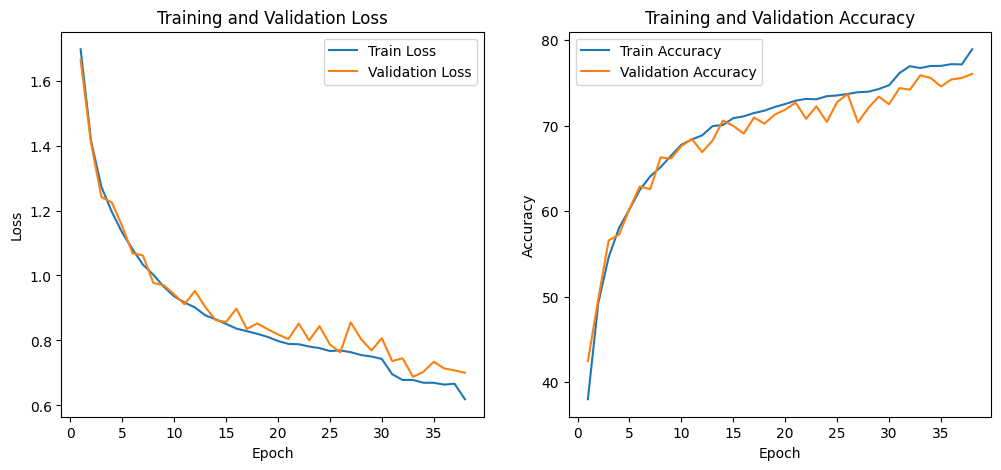

In [9]:
# Main training loop over optimizers and weight decay options, use learning rate scheduler to change learning rate in training
for optimizer_name in optimizers:
    for wd in weight_decay_options:
        print(f"\nTraining model with {optimizer_name} optimizer and weight decay {wd}")
        model = models.resnet18(num_classes=10)
        # Define optimizer
        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=wd)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=wd)
            #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True)

        # Loss function
        criterion = nn.CrossEntropyLoss()

        # Train and validate the model
        train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler)



In [10]:
# Testing model
def test_model(model_path, test_loader):
    model = models.resnet18(num_classes=10)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f'Test Accuracy: {100. * correct / total:.2f}%')

test_model('/content/drive/MyDrive/DLassignment2/models/resnet18_best.pth', test_loader)

<ipython-input-10-c3279aa1cf75>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Accuracy: 80.81%


In [ ]:
train_losses = [
   ]

val_losses = []

train_accuracies = []

val_accuracies = [
]


In [ ]:
len(train_losses)

50

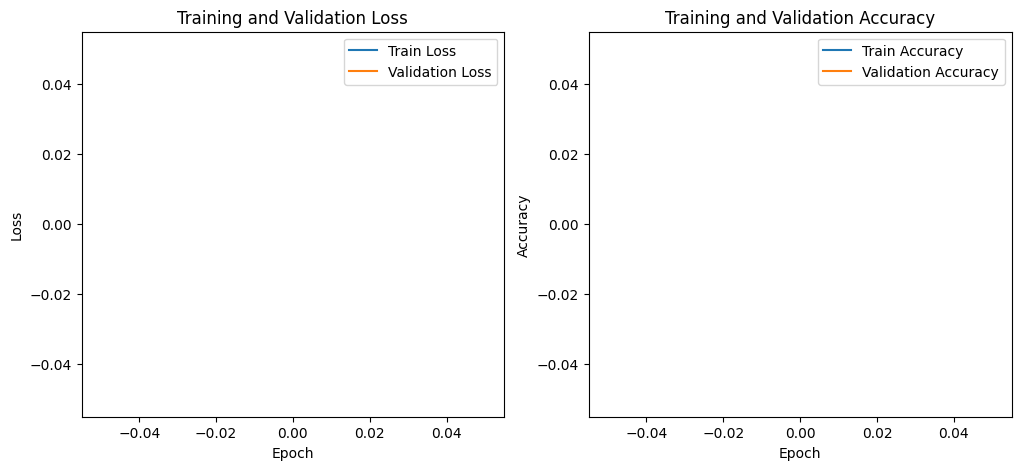

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)